## Set-up

In [149]:
import torch
from torch.utils.data import Dataset
import matplotlib
import matplotlib.pyplot as plt
import time
import numpy as np
import string
import unicodedata


In [150]:
# Check if CUDA is available
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

torch.set_default_device(device)
print(f"Using device = {torch.get_default_device()}")

Using device = cpu


## Prepare and load Data

In [151]:
allowed_characters = string.ascii_letters + " .,;'"
n_letters = len(allowed_characters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in allowed_characters
    )

In [152]:
%run -i 'namesdataset.py'

-- Initiate Dataset declaration
-- Dataset declaration finalized


In [153]:
alldata = NamesDataset("../data/names")
print(f"loaded {len(alldata)} items of data")
print(f"example = {alldata[0]}")

loaded 20074 items of data
example = (tensor([5]), tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]]), 'Czech', 'Abl')


In [154]:
train_set, test_set = torch.utils.data.random_split(alldata, [.85, .15], generator=torch.Generator(device=device).manual_seed(2024))

print(f"train examples = {len(train_set)}, validation examples = {len(test_set)}")

train examples = 17063, validation examples = 3011


## Prepare model

In [182]:
%run -i './dnn.py'

-- Initiate model and training declaration
-- Finished model and training declaration


In [183]:
n_hidden = 128
dnn = DeepANN(n_letters, n_hidden, len(alldata.labels_uniq))
print(dnn)

/mnt/disks/pgm/miniconda3/envs/torch310/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


DeepANN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_deep_stack): Sequential(
    (0): Linear(in_features=57, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=18, bias=True)
  )
  (softmax): LogSoftmax(dim=1)
)


In [184]:
print('Pre-training sample output:')
input = lineToTensor('Albert')
output = dnn(input) #this is equivalent to ``output = dnn.forward(input)``
print(output)
print(label_from_output(output, alldata.labels_uniq))

Pre-training sample output:
tensor([[-2.7608, -2.9829, -2.9944, -2.8776, -3.0327, -3.0074, -2.9048, -2.8963,
         -2.8754, -2.9894, -2.7840, -2.7707, -2.8166, -2.9013, -3.0117, -2.8336,
         -2.7921, -2.8646]], grad_fn=<LogSoftmaxBackward0>)
('English', 0)


In [185]:
start = time.time()
all_losses = train(dnn, train_set, n_epoch=27, learning_rate=0.15, report_every=5)
end = time.time()
print(f"training took {end-start}s")

training on data set with n = 17063
5 (19%): 	 average batch loss = 0.7981214030034423
10 (37%): 	 average batch loss = 0.6846667951659152
15 (56%): 	 average batch loss = 0.6137492580081839
20 (74%): 	 average batch loss = 0.5662984625478918
25 (93%): 	 average batch loss = 0.5321580715007765
training took 71.01019549369812s


In [178]:
print('Post-training sample output:')

input = lineToTensor('Albert')
output = dnn(input) #this is equivalent to ``output = dnn.forward(input)``
print(output)
print(label_from_output(output, alldata.labels_uniq))

Post-training sample output:
tensor([[-3.0424, -2.7761, -2.8326, -2.7770, -2.9690, -2.9729, -2.8705, -2.8821,
         -2.9022, -2.9692, -2.9319, -2.8713, -2.9936, -2.7764, -2.9781, -2.8422,
         -2.9045, -2.7932]], grad_fn=<LogSoftmaxBackward0>)
('Chinese', 1)


In [186]:
all_losses = np.array(all_losses)
all_losses

array([1.27491937, 1.0093265 , 0.90375414, 0.84159602, 0.7981214 ,
       0.76689443, 0.74164932, 0.71770737, 0.70206246, 0.6846668 ,
       0.66656655, 0.65042145, 0.63285174, 0.62462924, 0.61374926,
       0.60154352, 0.59406384, 0.58077615, 0.57421657, 0.56629846,
       0.5555422 , 0.54886388, 0.5446452 , 0.53668849, 0.53215807,
       0.52538959, 0.51823172])

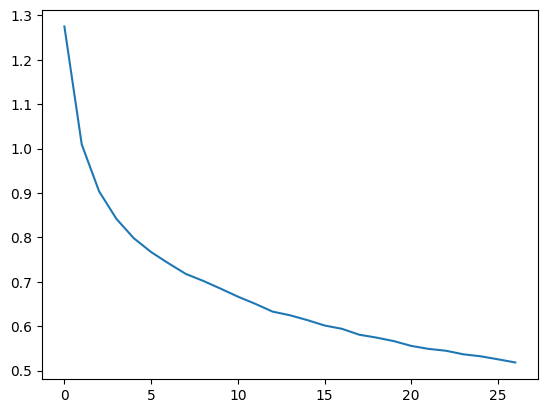

In [189]:
plt.figure()
plt.plot(all_losses)
plt.show()

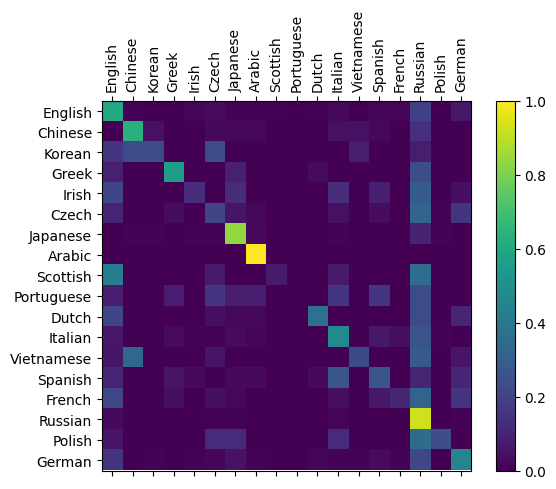

In [190]:
evaluate(dnn, test_set, classes=alldata.labels_uniq)